https://nlp.seas.harvard.edu/annotated-transformer/

https://www.kaggle.com/code/cyrillecervantes/arrhythmia-detection-using-transformer/notebook

# Arrhythmia Detection Using Transformer

In [1]:
import os
import copy
import pandas as pd
import math

# Pytorch
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.optim import Adam

# Pytorch Lightning
from pytorch_lightning import LightningModule, LightningDataModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

# Torchmetric for computing accuracy
from torchmetrics.functional import accuracy

# Plotting
import matplotlib.pyplot as plt

In [2]:
import pytorch_lightning as pl
print(pl.__version__)

1.9.0


In [3]:
# torch.set_float32_matmul_precision('medium') 

In [4]:
def load_list(root, filename):
    filepath = os.path.join(root, filename)
    output = pd.read_csv(filepath, header=None)
    return output

class MITBIHArrhythmia(Dataset):
    def __init__(self, root, subset=None):
        assert subset is None or subset in ["training", "validation", "testing"], (
            "When `subset` is not None, it must be one of {'training', 'validation', 'testing'}."
        )
        self.root = root
        file_dict = {
            "training": "mitbih_train.csv",
            "validation": "mitbih_test.csv",  # Assuming same file for both test and validation
            "testing": "mitbih_test.csv"
        }
        
        if subset is None:
            raise ValueError("Subset must be specified as 'training', 'validation', or 'testing'")
        
        # Load the data file as a DataFrame
        self._walker = load_list(self.root, file_dict[subset])
        
    def __len__(self):
        return len(self._walker)

    def __getitem__(self, n: int):
        # Access the nth row, convert it to a list, and split data from label
        row = self._walker.loc[n, :].values.tolist()
        label = row.pop()  # Last element is assumed to be the label
        return row, label


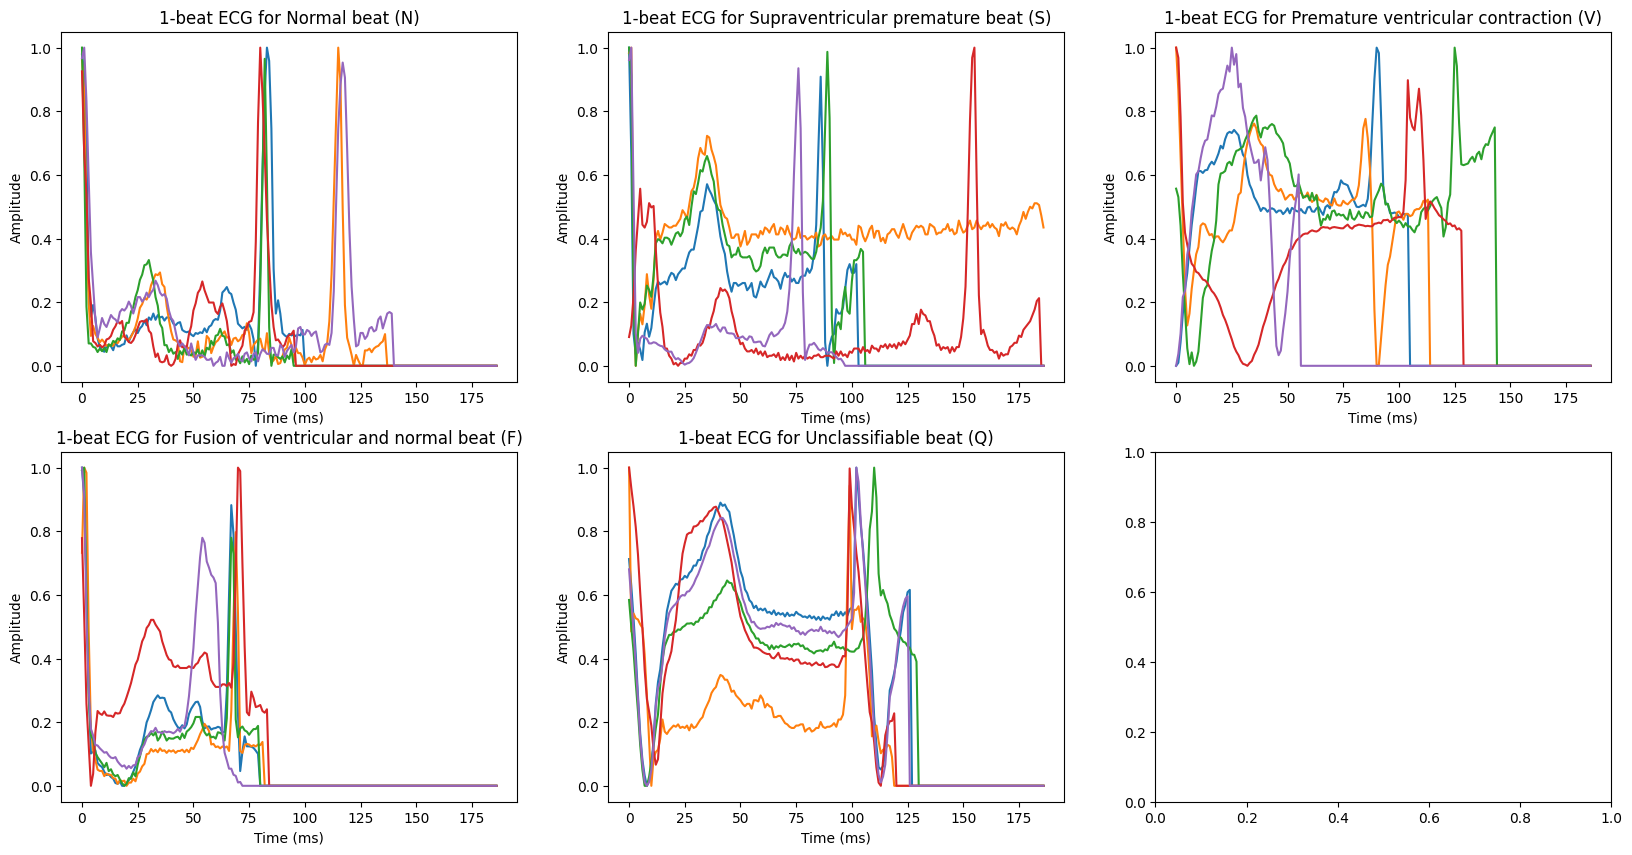

In [5]:
ds = MITBIHArrhythmia("./Heartbeat_Dataset", "training")

CLASSES_DICT = {
    0: "Normal beat (N)",
    1: "Supraventricular premature beat (S)",
    2: "Premature ventricular contraction (V)",
    3: "Fusion of ventricular and normal beat (F)",
    4: "Unclassifiable beat (Q)"
}
class_to_dsindx = {0:0, 1:72471, 2:74694, 3:80482, 4:81123}
# 0 starts at index 0, 1 starts at index 72471, 2 starts at index 74694
# 3 starts at index 80482, 4 starts at index 81123

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for cat, value in CLASSES_DICT.items():
    ax = axes[int(cat/3), cat%3]
    for j in range(5):
        indx = class_to_dsindx[cat]
        ax.plot(ds[indx+j][0])
    ax.set(title=f"1-beat ECG for {CLASSES_DICT[cat]}")
    ax.set(ylabel="Amplitude")
    ax.set(xlabel="Time (ms)")
plt.show()

In [6]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


#### ATTENTION
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = scores.softmax(dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.0):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1) # Same mask applied to all h heads.

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [
            lin(x).view( -1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = (x.transpose(1, 2).contiguous().view( -1, self.h * self.d_k))
        
        del query
        del key
        del value
        out = self.linears[-1](x)
        return out

## BLOCKING
class LayerNorm(nn.Module):
    "Construct a layernorm module."
    def __init__(self, features, eps=1e-6):
        super().__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

class SublayerConnection(nn.Module):
    "A residual connection followed by a layer norm."
    def __init__(self, size, dropout):
        super().__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

class EncoderBlock(nn.Module):
    "Encoder is made up of self-attn and feed forward"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super().__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        x = self.sublayer[1](x, self.feed_forward)
        return x

class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask=None):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

class FeedForward(nn.Module):
    "Construct a FeedForward network with one hidden layer"
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class Transformer(nn.Module):
    "Transformer Model"
    def __init__(self, input_size, num_classes, num_heads=8, N=6, d_ff=256, dropout=0.0):
        super().__init__()
        c = copy.deepcopy
        attn = MultiHeadedAttention(num_heads, input_size)
        ff = FeedForward(input_size, d_ff, dropout)
        self.encoder = Encoder(EncoderBlock(input_size, c(attn), c(ff), dropout), N)
        self.fc = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.fc(x)
        return x

In [7]:
class LitMITBIH(LightningDataModule):
    def __init__(self, root, batch_size, num_workers, length=200):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.path = root
        self.length = length
    
    def prepare_data(self):
        self.train_dataset = MITBIHArrhythmia(self.path, "training")
        self.val_dataset = MITBIHArrhythmia(self.path, "validation")
        self.test_dataset = MITBIHArrhythmia(self.path, "testing")
    
    def setup(self, stage=None):
        self.prepare_data()

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True,
            collate_fn=self.collate_fn
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False, 
            pin_memory=True,
            collate_fn=self.collate_fn
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False, 
            pin_memory=True,
            collate_fn=self.collate_fn
        )

    def collate_fn(self, batch):
        labels = []
        heartbeats = []
        for sample in batch:
            waveform, label = sample
            if len(waveform) < self.length:
                padsize = self.length - len(waveform)
                waveform += [0]*padsize

            labels.append(torch.tensor(label).type(torch.int64))
            heartbeats.append(torch.tensor(waveform))

        labels = torch.stack(labels)
        heartbeats = torch.stack(heartbeats)
        return heartbeats, labels
    
from torchmetrics import Accuracy

class LitTransformer(LightningModule):
    def __init__(self, input_size, num_classes, num_heads, depth, max_epochs, lr, dropout=0.1, d_ff=256):
        super().__init__()
        self.save_hyperparameters()
        self.model = Transformer(input_size, num_classes, num_heads, depth, d_ff, dropout)
        self.loss = torch.nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.reset_parameters()

    def reset_parameters(self):
        for p in self.model.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer  # Add scheduler if needed

    def training_step(self, batch, batch_idx):
        wavs, labels = batch
        preds = self(wavs)
        loss = self.loss(preds, labels)
        
        # Log training loss
        self.log('train_loss', loss)

        # Log accuracy using the class instance
        acc = self.accuracy(preds.softmax(dim=-1), labels) * 100.0
        self.log('train_acc', acc)

        return {"loss": loss}
    
    def on_training_epoch_end(self):
        avg_loss = torch.stack([x["loss"] for x in self.trainer.callback_metrics]).mean()
        self.log("train_loss", avg_loss, on_epoch=True)
    
    def validation_step(self, batch, batch_idx):
        wavs, labels = batch
        preds = self(wavs)
        loss = self.loss(preds, labels)
        
        # Log validation loss and accuracy
        self.log('val_loss', loss)
        acc = self.accuracy(preds.softmax(dim=-1), labels) * 100.0
        self.log('val_acc', acc)

        return {"preds": preds, 'val_loss': loss, 'val_acc': acc}

    def on_validation_epoch_end(self):
        avg_loss = torch.stack([self.trainer.callback_metrics['val_loss']]).mean()
        avg_acc = torch.stack([self.trainer.callback_metrics['val_acc']]).mean()
        self.log("val_loss", avg_loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", avg_acc, on_epoch=True, prog_bar=True)



    def test_step(self, batch, batch_idx):
        wavs, labels = batch
        preds = self(wavs)
        loss = self.loss(preds, labels)
        acc = self.accuracy(preds.softmax(dim=-1), labels) * 100.0
        self.log('test_acc', acc, prog_bar=True)
        return {"preds": preds, 'test_loss': loss, 'test_acc': acc}

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['test_acc'] for x in outputs]).mean()
        self.log("test_loss", avg_loss, on_epoch=True, prog_bar=True)
        self.log("test_acc", avg_acc, on_epoch=True, prog_bar=True)


In [8]:
path = "./heartbeat_Dataset"
input_size = 200
batch_size = 128
num_workers = 0
lr = 1e-4
max_epochs = 22
num_heads = 5
depth = 6
num_classes = 5
dropout = 0.0

datamodule = LitMITBIH( path, batch_size, num_workers, length=input_size)
datamodule.setup()

train_loader = datamodule.train_dataloader()
val_loader = datamodule.val_dataloader()
test_loader = datamodule.test_dataloader()

# Verify that loaders are not empty and that they produce batches of data
for batch in train_loader:
    print("Train Batch:", batch)
    break
for batch in val_loader:
    print("Validation Batch:", batch)
    break
for batch in test_loader:
    print("Test Batch:", batch)
    break


model = LitTransformer(input_size, num_classes, num_heads, depth, max_epochs, lr, dropout)
print(model)

Train Batch: [tensor([[0.9472, 0.8894, 0.6231,  ..., 0.0000, 0.0000, 0.0000],
        [0.9496, 0.7240, 0.2344,  ..., 0.0000, 0.0000, 0.0000],
        [1.0000, 0.7030, 0.2335,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.9044, 0.7703, 0.4180,  ..., 0.0000, 0.0000, 0.0000],
        [1.0000, 0.7919, 0.3108,  ..., 0.0000, 0.0000, 0.0000],
        [0.9583, 0.7578, 0.2578,  ..., 0.0000, 0.0000, 0.0000]]), tensor([0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 4, 4,
        4, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 4, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 4, 0,
        0, 0, 0, 0, 0, 0, 0, 0])]
Validation Batch: [tensor([[1.0000, 0.7583, 0.1116,  ..., 0.0000, 0.0000, 0.0000],
        [0.9084, 0.7839, 0.5311,  ..., 0.0000, 0.0000, 0.0000],
      

In [9]:
save_path = "./model/"
ckpt_name = "ecg-transformer"

In [10]:


model_checkpoint = ModelCheckpoint(
    dirpath=os.path.join(save_path, "checkpoints"),
    filename=ckpt_name,
    save_top_k=1,
    verbose=True,
    monitor='val_acc',
    # monitor='test_acc',
    mode='max',
)


trainer = Trainer(accelerator="gpu", devices=1,

                    max_epochs=max_epochs,
                    logger=False,
                    callbacks=[model_checkpoint]
                )

history=trainer.fit(model, datamodule=datamodule)
# trainer.fit(model, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | model    | Transformer        | 1.6 M 
1 | loss     | CrossEntropyLoss   | 0     
2 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.353     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\randa\OneDrive\Documents\GitHub\Neural-Networks-Project\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\randa\OneDrive\Documents\GitHub\Neural-Networks-Project\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 685: 'val_acc' reached 96.95322 (best 96.95322), saving model to './model/checkpoints\\ecg-transformer.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1370: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2055: 'val_acc' reached 97.44199 (best 97.44199), saving model to './model/checkpoints\\ecg-transformer.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 2740: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 3425: 'val_acc' reached 97.48310 (best 97.48310), saving model to './model/checkpoints\\ecg-transformer.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 4110: 'val_acc' reached 97.52421 (best 97.52421), saving model to './model/checkpoints\\ecg-transformer.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 4795: 'val_acc' reached 97.62927 (best 97.62927), saving model to './model/checkpoints\\ecg-transformer.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 5480: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 6165: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 6850: 'val_acc' reached 97.70235 (best 97.70235), saving model to './model/checkpoints\\ecg-transformer.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 7535: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 8220: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 8905: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 9590: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 10275: 'val_acc' reached 97.72977 (best 97.72977), saving model to './model/checkpoints\\ecg-transformer.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 10960: 'val_acc' reached 97.83026 (best 97.83026), saving model to './model/checkpoints\\ecg-transformer.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 11645: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 12330: 'val_acc' reached 97.83482 (best 97.83482), saving model to './model/checkpoints\\ecg-transformer.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 13015: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 13700: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 14385: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 15070: 'val_acc' reached 97.84853 (best 97.84853), saving model to './model/checkpoints\\ecg-transformer.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=22` reached.


In [12]:
# Testing
print(f"Loading checkpoint: {ckpt_name}.ckpt")
model = model.load_from_checkpoint(
    os.path.join(save_path, "checkpoints", ckpt_name+".ckpt")
)
trainer.test(model, datamodule=datamodule)

Loading checkpoint: ecg-transformer.ckpt


c:\Users\randa\OneDrive\Documents\GitHub\Neural-Networks-Project\.venv\Lib\site-packages\lightning_fabric\utilities\cloud_io.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featur

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     97.86064910888672     │
│         test_loss         │    0.12301717698574066    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 97.86064910888672, 'test_loss': 0.12301717698574066}]